# Imports

In [94]:
import nest
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import importlib
import constants
import random
importlib.reload(constants)
from constants import *

nest.set_verbosity("M_ERROR") # SHUT UP NEST
nest.ResetKernel()

In [95]:
plt.ion()

## Introduction

Our main objective in this notebook is to simulate a hyperexcitable state in cortical networks,an effect that has been hypothesized to occur in autism due to the overpruning of long-range connections. In our model, we assume that long-range connections primarily provide inhibitory, modulatory control, whereas short-range connections are predominantly excitatory. This enforced connectivity scheme is intended to represent a “macro-scale” view within a relatively small network where each neuron approximates the activity of a larger cortical region.

By adopting this approach, we aim to demonstrate how the overpruning of long-range (inhibitory/modulatory) connections may lead to a loss of network integration, thereby impairing efficient communication between regions. It is important to note that although in biological cortical networks most long-range projections are excitatory, there is evidence that inhibitory modulation via long-range interactions can play a pivotal role in regulating neural dynamics, synchronizing oscillations, and maintaining overall network stability

## Helper functions for plotting connectivity

In [96]:
def get_positions(neurons) -> np.ndarray:
    """
    Get the positions of a list of neurons.
    (Assumes that nest.GetStatus(neurons, 'positions') returns a list of positions.)
    """
    return np.array(nest.GetPosition(neurons))

def get_positions_dict(layer_e, layer_i):
    """
    Returns dictionaries mapping neuron id -> position for excitatory and inhibitory populations.
    """
    positions_exc = {
        neuron: pos for neuron, pos in zip(layer_e, get_positions(layer_e))
    }
    positions_inh = {
        neuron: pos for neuron, pos in zip(layer_i, get_positions(layer_i))
    }
    return positions_exc, positions_inh

def spatial_distribution(layer_e, layer_i, fig=None, ax=None): 
    """
    Plot the spatial distribution of excitatory and inhibitory neurons

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    Returns:
        fig (matplotlib.figure.Figure): Figure object
        ax1 (matplotlib.axes.Axes): Axes object
        ax2 (matplotlib.axes.Axes): Axes object
    """

    positions_e = get_positions(layer_e)
    positions_i = get_positions(layer_i)

    if fig is None or ax is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    else:
        ax1, ax2 = ax
    ax1.scatter(positions_e[:, 0], positions_e[:, 1], c='blue', label='Excitatory')
    ax1.scatter(positions_i[:, 0], positions_i[:, 1], c='red', label='Inhibitory')
    ax1.set_title("Spatial Distribution of Neurons")
    ax1.legend()

    
    fig.tight_layout()
    
    return fig, ax1, ax2

def find_positions(layer_e, layer_i):
    positions_exc = [(i + 1, pos) for i, pos in enumerate(layer_e.spatial["positions"])]
    start_index_inh = len(positions_exc) + 1 
    positions_inh = [(i + start_index_inh, pos) for i, pos in enumerate(layer_i.spatial["positions"])]
    # print(positions_exc)
    # print(positions_inh)
    
    positions_exc_dict = {neuron_id: pos for neuron_id, pos in positions_exc}
    positions_inh_dict = {neuron_id: pos for neuron_id, pos in positions_inh}

    return positions_exc_dict, positions_inh_dict

    
def find_plot_connections(connections, layer_e, layer_i, fig, ax1, ax2):
    """
    Visualize the connections between the neurons and plot the connectivity matrix

    Args:
        connections (list): List of connections
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
        fig (matplotlib.figure.Figure): Figure object
        ax1 (matplotlib.axes.Axes): Axes object
        ax2 (matplotlib.axes.Axes): Axes object
    """
    # source_node = int(input("Enter the source node: "))
    if isinstance(connections, list):
        all_connections = []
        for conn_collection in connections:
            all_connections.extend(list(conn_collection))  # Convert SynapseCollection to list of dictionaries
    else:
        all_connections = list(connections)  # Convert SynapseCollection to list of dictionaries
    
    source_node = 5
    center_neuron = nest.FindCenterElement(layer_e)
    cn_coords = center_neuron.spatial['positions']
   
    positions_exc, positions_inh = find_positions(layer_e, layer_i)
    print(positions_exc)
    print(positions_inh)

    source_pos = positions_exc.get(source_node) or positions_inh.get(source_node)
    if source_pos is None:
        print(f"Source node {source_node} not found in the network.")
    else:
        ax1.scatter(source_pos[0], source_pos[1], c='purple', label=f'Source Node {source_node}')

    for conn in all_connections:
        if conn.get("source") == source_node:
            target_node = conn.get("target")
            target_pos = positions_exc.get(target_node) or positions_inh.get(target_node)
            if target_pos is not None:
                ax1.plot([source_pos[0], target_pos[0]],
                         [source_pos[1], target_pos[1]],
                         c='black', alpha=0.2)

    fig.tight_layout()
    plot_connectivity_matrix(len(layer_e) + len(layer_i), all_connections, ax2)
    plt.show()

def plot_connectivity_matrix(total_neurons, connection_details, ax):
    """
    Plot the connectivity matrix of the network

    Args:
    """
    weight_matrix = np.zeros((total_neurons, total_neurons))
    for conn in connection_details:
        # Adjust for Python 0-indexing (assumes neuron IDs start at 1)
        source = conn.get("source") - 1
        target = conn.get("target") - 1
        weight = conn.get("weight")
        weight_matrix[source, target] = weight

    print(weight_matrix)
    sns.heatmap(weight_matrix, cmap='viridis', ax=ax)

## Setup

In order to have synapses change through time such that we could apply pruning with respect to a threshold we decided to use the phenomenological model for short term plasticity for the connections in the excitatory neurons. Short-term synaptic plasticity contributes to the balance and regulation of brain networks from milliseconds to several minutes. The model comprises of 4 different state variables, but we mainly focus in the recovery variable $x(t)$ and the used resources variable $u(t)$

The model describes three state variables representing the synaptic resources:

- **Recovered or resting state**, with occupancy $x$
- **Active or conducting state**, $y$
- **Inactive state**, $z$

These satisfy the conservation equation:

$$
x + y + z = 1
$$

A fourth state variable, $u$, describes the "use" of synaptic resources in response to a presynaptic action potential arriving at $t = t_0$:

$$
\frac{du}{dt} = -\frac{u}{\tau_{\text{facil}}} + U(1 - u) \delta (t - t_0)
$$

where $u$ increases by $U(1 - u)$ with each action potential and decays back to zero with a time constant $\tau_{\text{facil}}$.

This $u$ drives the dynamics of the other three state variables:

$$
\frac{dx}{dt} = \frac{z}{\tau_{\text{rec}}} - u x \delta (t - t_0)
$$

$$
\frac{dy}{dt} = -\frac{y}{\tau_{\text{decay}}} + u x \delta (t - t_0)
$$

$$
\frac{dz}{dt} = \frac{y}{\tau_{\text{decay}}} - \frac{z}{\tau_{\text{rec}}}
$$

We decided to use a very small value of $U$ such that we have slow increments for $u(t)$, also to not have a strong facilitation effect we kept $\tau_{\text{facil}}$ << $\tau_{\text{rec}}$ thus having a fast enough reovery after each pre-synaptic spike

To stabilize excitatory neuron activity and achieve a balanced network, we implement an integrate-and-fire model with adaptive conductance. In this model, each spike increases the adaptive conductance, which temporarily reduces the neuron's excitability. This mechanism helps stabilize the firing rate when a constant stimulus is presented

*Note* : All values of the parameters can be found in the `constans.py` file


In [97]:
def create_populations():
    """
    Create populations of excitatory and inhibitory neurons with spatial distribution

    Returns:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """
    E_neuron_params = {
        "E_L": E_NEURON_E_L,
        "C_m": E_NEURON_C_M,
        "t_ref": E_NEURON_T_REF,
        "V_th": E_NEURON_V_TH,
        "V_reset": E_NEURON_V_RESET,
        "tau_syn_ex": E_NEURON_TAU_SYN_EX,
        "tau_syn_in": E_NEURON_TAU_SYN_IN,
        "a": ADAPTATION_a,         
        "b": ADAPTATION_b,         
        "tau_w": ADAPTATION_tau_w  
    }

    I_neuron_params = {
        "E_L": I_NEURON_E_L,
        "C_m": I_NEURON_C_M,
        "tau_m": I_NEURON_TAU_M,
        "t_ref": I_NEURON_T_REF,
        "V_th": I_NEURON_V_TH,
        "V_reset": I_NEURON_V_RESET,
        "tau_syn_ex": I_NEURON_TAU_SYN_EX,
        "tau_syn_in": I_NEURON_TAU_SYN_IN,
        "I_e": INH_BACKGROUND
    }

    pop_size_E = POP_SIZE_E
    pop_size_I = POP_SIZE_I


    nest.CopyModel("aeif_cond_alpha", "exc_iaf_psc_alpha")
    nest.SetDefaults("exc_iaf_psc_alpha", E_neuron_params)

    nest.CopyModel("iaf_psc_alpha", "inh_iaf_psc_alpha")
    nest.SetDefaults("inh_iaf_psc_alpha", I_neuron_params)

    # random distribution of neurons in the 2d space
    pos_e = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )
    pos_i = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )

    # creating the two populations
    layer_e = nest.Create("exc_iaf_psc_alpha", n=pop_size_E, positions=pos_e)
    layer_i = nest.Create("inh_iaf_psc_alpha", n=pop_size_I, positions=pos_i)
    
    return layer_e, layer_i

def connect_pop_base(layer_e, layer_i):
    """
    Connect the populations with specific spatial synaptic rules

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """

    # Useful for plotting
    figT, ax1, ax2 = spatial_distribution(layer_e, layer_i)

    # Distance‐dependent connection rule for short range connectivity
    distribution_exc = nest.spatial_distributions.gaussian(nest.spatial.distance, std=EXC_GAUSSIAN_STD)
    conndict_exc = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution_exc > EXC_DISTRIBUTION_THRESHOLD, distribution_exc, 0),
        "mask": {"circular": {"radius": EXC_MASK_RADIUS}},
    }

    # Distance‐dependent connection rule for long range connectivity
    distribution_inh = nest.spatial_distributions.gaussian(nest.spatial.distance, std=INH_GAUSSIAN_STD)
    conndict_inh = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution_inh > INH_DISTRIBUTION_THRESHOLD, distribution_inh, 0),
        "mask": {"circular": {"radius": INH_MASK_RADIUS}},
    }

    # Define synapse parameters
    syn_params = {
        "U": 0.04,
        "u": 0.0,
        "tau_rec": 500.0,
        "tau_fac": 400.0,
        "weight" : EXC_WEIGHT
    }
    nest.CopyModel("tsodyks_synapse", "synapse", syn_params)

    # Define inhibitory synapse parameters
    static_inh_params = {
        "weight": INH_WEIGHT,  
        "delay": DELAY_CONNECTION 
    }
    nest.CopyModel("static_synapse", "inhibitory_synapse", static_inh_params)

    # Excitatory to excitatory: local (short-range)
    nest.Connect(layer_e, layer_e, conndict_exc, syn_spec={"synapse_model": "synapse"})
    # Excitatory to inhibitory: local (excite inhibitory neurons in the vicinity)
    nest.Connect(layer_e, layer_i, conndict_exc, syn_spec={"synapse_model": "synapse"})
    
    # Inhibitory to excitatory: long-range (inhibitory neurons can influence distant targets)
    nest.Connect(layer_i, layer_e, conndict_inh, syn_spec={"synapse_model": "inhibitory_synapse"})
    # Inhibitory to inhibitory: long-range as well
    nest.Connect(layer_i, layer_i, conndict_inh, syn_spec={"synapse_model": "inhibitory_synapse"})

    connections_exc = nest.GetConnections(synapse_model="synapse")
    connections_inh = nest.GetConnections(synapse_model="inhibitory_synapse")
    print("Number of excitatory connections: ", len(connections_exc))
    print("Number of inhibitory connections: ", len(connections_inh))

    all_connections = [connections_exc, connections_inh]

    find_plot_connections(all_connections, layer_e, layer_i, figT, ax1, ax2)

def create_thalamic_input(layer_e, firing_rate=THALAMIC_INPUT_FIRING_RATE, weight=THALAMIC_INPUT_WEIGHT, delay=THALAMIC_INPUT_DELAY):
    """
    Create a Poisson generator to simulate thalamic input to the excitatory neurons
    """
    thalamic_input = nest.Create("poisson_generator", params={"rate": firing_rate})
    nest.Connect(thalamic_input, layer_e, syn_spec={"weight": weight, "delay": delay}) 
    return thalamic_input

def create_dc_input(layer_e, start = DC_INPUT_START_1, stop=DC_INPUT_STOP_1):
    """
    Create a DC generator to simulate a constant input to the excitatory neurons
    """
    dc_input = nest.Create("dc_generator")
    
    nest.SetStatus(dc_input, {
        "amplitude": DC_INPUT_AMPLITUDE,  # pA (adjust based on your neuron model)
        "start": start,   # ms (start time)
        "stop": stop    # ms (stop time)
        })
    
    nest.Connect(dc_input, layer_e, syn_spec={"weight": DC_INPUT_WEIGHT, "delay": DC_INPUT_DELAY})

    return dc_input

## Monitoring

In [98]:
def recording_devices(layer_e, layer_i, input = None):
    """
    Connect recording devices
    """
    sr_e = nest.Create("spike_recorder")
    sr_i = nest.Create("spike_recorder")
    nest.Connect(layer_e, sr_e)
    nest.Connect(layer_i, sr_i)

    if input:
        sr_input = nest.Create("spike_recorder")
        nest.Connect(input, sr_input)

    multimeter_e = nest.Create("multimeter", params={
    "record_from": ["V_m", "w"],  # Record membrane potential and adaptation
    "interval": 0.1})

    # multimeter_e = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    multimeter_i = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    nest.Connect(multimeter_e, layer_e[0])
    nest.Connect(multimeter_i, layer_i)

    sr_input = None
    
    return multimeter_e, multimeter_i, sr_e, sr_i, sr_input

def plot_spikes(sr_e, sr_i, sr_input = None):
    spike_events_e = nest.GetStatus(sr_e, "events")[0]
    spike_events_i = nest.GetStatus(sr_i, "events")[0]
    
    senders_e = spike_events_e["senders"]
    times_e = spike_events_e["times"]
    senders_i = spike_events_i["senders"]
    times_i = spike_events_i["times"]

    if sr_input:
        # poisson generator
        spike_events_input = nest.GetStatus(sr_input, "events")[0]
        # print(spike_events_input)
        senders_input = spike_events_input["senders"]
        times_input = spike_events_input["times"]

    dots_size = 3

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(times_e, senders_e, s=dots_size, label="Excitatory", color="red")
    ax.scatter(times_i, senders_i, s=dots_size, label="Inhibitory", color="blue")
    if sr_input:
        ax.scatter(times_input, senders_input, s=dots_size, label="Input", color="orange")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Neuron ID")
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_voltages(multimeter_e, multimeter_i):
    multimeter_events_e = nest.GetStatus(multimeter_e, "events")[0]
    multimeter_events_i = nest.GetStatus(multimeter_i, "events")[0]

    w = multimeter_events_e["w"]      # Adaptation variable
    senders_e = multimeter_events_e["senders"]  # Neuron IDs

    times_e = multimeter_events_e["times"]
    voltages_e = multimeter_events_e["V_m"]
    times_i = multimeter_events_i["times"]
    voltages_i = multimeter_events_i["V_m"]


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7, 5))
    ax1.plot(times_e, voltages_e, label="Excitatory", color="red")
    ax1.plot(times_i, voltages_i, label="Inhibitory", color="blue")
    ax1.set_xlabel("Time (ms)")
    ax1.set_ylabel("Membrane potential (mV)")
    ax1.legend()
    ax2.plot(times_e, w, label=f"Neuron {senders_e[0]}", color="green")
    plt.tight_layout()
    plt.show()

def plot_firing_rate(sr_e, sr_i, sim_time):
    bin_size = BIN_SIZE
    time_vector = np.arange(0, sim_time, bin_size)
    dc_current = np.zeros_like(time_vector, dtype=float)
    dc_current[(time_vector >= DC_INPUT_START) & (time_vector < DC_INPUT_STOP)] = DC_INPUT_AMPLITUDE


# Network Setup

Number of excitatory connections:  11640
Number of inhibitory connections:  9462
{1: (-0.40798108195970145, 0.2970795658444456), 2: (0.48645561495467693, 0.4022864445518274), 3: (0.07331696778221763, 0.49660884341504674), 4: (0.2971218129328491, 0.07112615885741058), 5: (-0.1764348515382232, 0.24632559879959925), 6: (-0.001314772777945894, 0.001906520942407286), 7: (0.13530694491137618, -0.4366609991874165), 8: (-0.49157719730693894, 0.36683756850479565), 9: (0.16781641030435057, 0.0395798325844563), 10: (-0.04360846894806514, -0.46975579553531327), 11: (0.44126109364783295, 0.39686660443017474), 12: (-0.32853874781696324, 0.47638299639808757), 13: (-0.49957795457057935, -0.0025996278275214335), 14: (0.002007131992430078, 0.03120272949291958), 15: (0.2120300831110613, -0.3201622049180636), 16: (0.4654134415518164, -0.20821677741505906), 17: (0.4817585109741961, -0.19447744139090017), 18: (0.2490527490270471, 0.27345372329697226), 19: (-0.11690487072563088, -0.11730444773866983), 20: (0

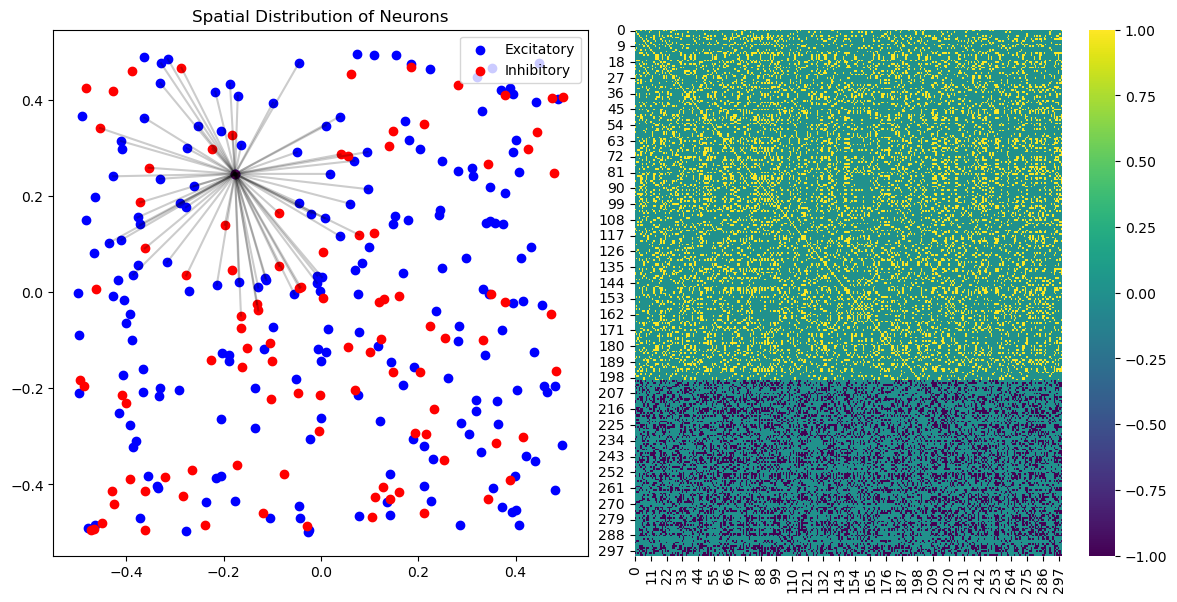

In [99]:
nest.ResetKernel()
layer_e, layer_i = create_populations()
connect_pop_base(layer_e, layer_i)
_ = create_dc_input(layer_e, start=DC_INPUT_START_1, stop=DC_INPUT_STOP_1)
_ = create_dc_input(layer_e, start=DC_INPUT_START_2, stop=DC_INPUT_STOP_2)
# input = None
input = create_thalamic_input(layer_e)
mr_e, mr_i, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, input)

# Monitoring Synapses Evolution

The following code:

1. splits the connections in exc-exc, exc-inh, inh-exc, inh-inh
2. simulate for each step for an amount of time defined by step_duration, for each steps it retrieves u and x values for each type of connection
3. plots with two scatter plots the progression of each type

Because we are using the Tsodyks model for excitatory synapses, we find it useful to monitor the evolution of its parameters, u and x, over the simulation time. By plotting the time course of u and x, we can verify that the short-term plasticity dynamics are behaving as expected. This monitoring not only provides insight into the underlying synaptic modulation but also helps ensure that the network dynamics remain stable and well-regulated during simulation

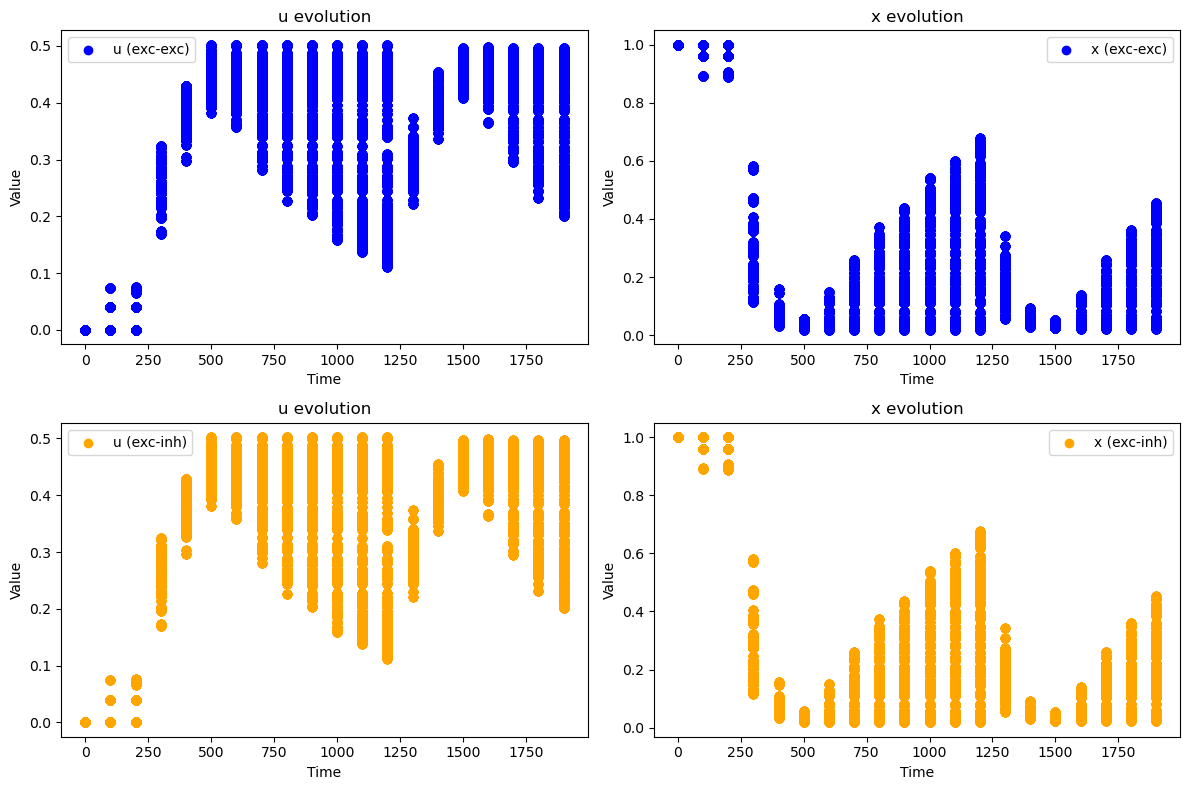

In [100]:
# GET SOME CONNECTIONS TO PLOT
exc_exc = nest.GetConnections(source=layer_e, target=layer_e, synapse_model="synapse")
exc_inh = nest.GetConnections(source=layer_e, target=layer_i, synapse_model="synapse")
inh_exc = nest.GetConnections(source=layer_i, target=layer_e, synapse_model="synapse")
inh_inh = nest.GetConnections(source=layer_i, target=layer_i, synapse_model="synapse")

steps = STEPS
step_duration = STEPS_DURATION
time = 0

# initialization
u_values_exc_exc, u_values_exc_inh, u_values_inh_exc, u_values_inh_inh = [], [], [], []
x_values_exc_exc, x_values_exc_inh, x_values_inh_exc, x_values_inh_inh = [], [], [], []

timesteps = [step_duration*step for step in range(steps)]

firing_rates = []
dc_current = []
time_steps_rate = []
n_spikes = 0

for i in range(steps):
    # Retrieve u and x Values
    u_values_exc_exc.append(nest.GetStatus(exc_exc, "u"))
    u_values_exc_inh.append(nest.GetStatus(exc_inh, "u"))
    u_values_inh_exc.append(nest.GetStatus(inh_exc, "u"))
    u_values_inh_inh.append(nest.GetStatus(inh_inh, "u"))

    x_values_exc_exc.append(nest.GetStatus(exc_exc, "x"))
    x_values_exc_inh.append(nest.GetStatus(exc_inh, "x"))
    x_values_inh_exc.append(nest.GetStatus(inh_exc, "x"))
    x_values_inh_inh.append(nest.GetStatus(inh_inh, "x"))
    time += step_duration
    nest.Simulate(step_duration)

    events = nest.GetStatus(sr_e, "n_events")[0]
    new_events = events - n_spikes
    n_spikes = events

    rate = new_events / (POP_SIZE_E * (step_duration / 1000.0))
    firing_rates.append(rate)
    time_steps_rate.append(time)

    if (DC_INPUT_START_1 <= time < DC_INPUT_STOP_1) or (DC_INPUT_START_2 <= time < DC_INPUT_STOP_2):
        dc_current.append(DC_INPUT_AMPLITUDE)
    else:
        dc_current.append(0)

u_exc_exc_flattened = np.concatenate(u_values_exc_exc)
u_exc_inh_flattened = np.concatenate(u_values_exc_inh)
u_inh_exc_flattened = np.concatenate(u_values_inh_exc)
u_inh_inh_flattened = np.concatenate(u_values_inh_inh)
x_exc_exc_flattened = np.concatenate(x_values_exc_exc)
x_exc_inh_flattened = np.concatenate(x_values_exc_inh)
x_inh_exc_flattened = np.concatenate(x_values_inh_exc)
x_inh_inh_flattened = np.concatenate(x_values_inh_inh)

fig, axes = plt.subplots(2, 2, figsize=(12, 8)) 

axes[0,0].scatter(np.repeat(timesteps, len(u_values_exc_exc[0])), u_exc_exc_flattened, color="blue", label="u (exc-exc)")
axes[1,0].scatter(np.repeat(timesteps, len(u_values_exc_inh[0])), u_exc_inh_flattened, color="orange", label="u (exc-inh)")
# axes[0].scatter(np.repeat(timesteps, len(u_values_inh_exc[0])), u_inh_exc_flattened, color="green", label="u (inh-exc)", alpha=0.8)
# axes[0].scatter(np.repeat(timesteps, len(u_values_inh_inh[0])), u_inh_inh_flattened, color="purple", label="u (inh-inh)", alpha=0.1)
axes[0,1].scatter(np.repeat(timesteps, len(x_values_exc_exc[0])), x_exc_exc_flattened, color="blue", label="x (exc-exc)")
axes[1,1].scatter(np.repeat(timesteps, len(x_values_exc_inh[0])), x_exc_inh_flattened, color="orange", label="x (exc-inh)")
# axes[1].scatter(np.repeat(timesteps, len(x_values_inh_exc[0])), x_inh_exc_flattened, color="green", label="x (inh-exc)", alpha=0.7)
# axes[1].scatter(np.repeat(timesteps, len(x_values_inh_inh[0])), x_inh_inh_flattened, color="purple", label="x (inh-inh)", alpha=0.7)

axes[0,0].set_xlabel("Time")
axes[0,0].set_ylabel("Value")
axes[0,0].set_title("u evolution")
axes[1,0].set_xlabel("Time")
axes[1,0].set_ylabel("Value")
axes[1,0].set_title("u evolution")
axes[1,1].set_xlabel("Time")
axes[1,1].set_ylabel("Value")
axes[1,1].set_title("x evolution")
axes[0,1].set_xlabel("Time")
axes[0,1].set_ylabel("Value")
axes[0,1].set_title("x evolution")
axes[0,0].legend()
axes[1,0].legend()
axes[0,1].legend()
axes[1,1].legend()
plt.tight_layout()
plt.show()

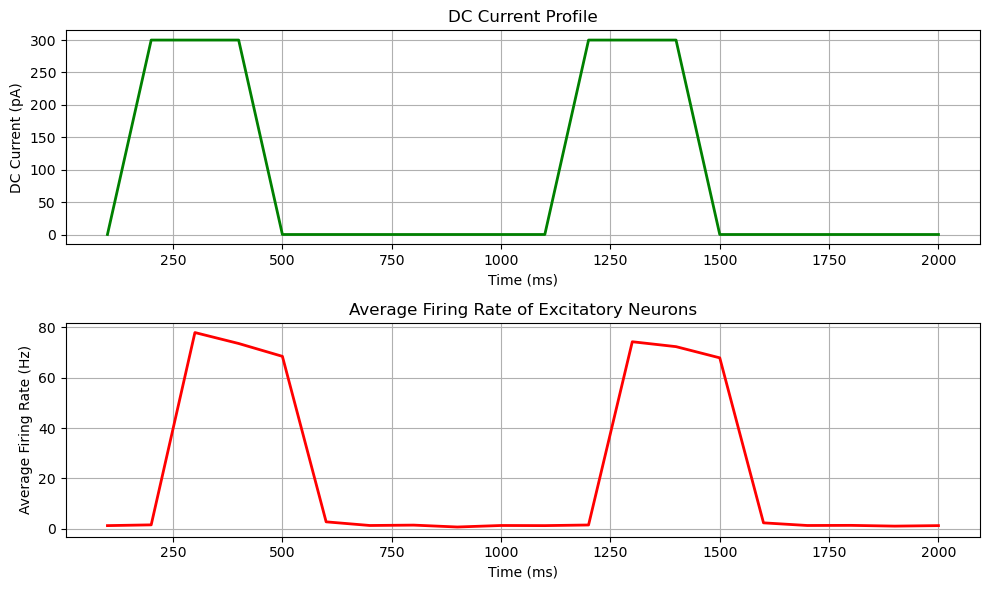

In [101]:
fig2, ax2 = plt.subplots(2, 1, figsize=(10, 6))

# DC Current Profile
ax2[0].plot(time_steps_rate, dc_current, lw=2, color="green")
ax2[0].set_xlabel("Time (ms)")
ax2[0].set_ylabel("DC Current (pA)")
ax2[0].set_title("DC Current Profile")
ax2[0].grid(True)

# Average Firing Rate
ax2[1].plot(time_steps_rate, firing_rates, lw=2, color="red")
ax2[1].set_xlabel("Time (ms)")
ax2[1].set_ylabel("Average Firing Rate (Hz)")
ax2[1].set_title("Average Firing Rate of Excitatory Neurons")
ax2[1].grid(True)

plt.tight_layout()
plt.show()

## Mean + STD

In the following i take the above measure and plot a summary of the values with mean and std

/home/nix/miniconda3/envs/ebrains_env/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning:Mean of empty slice.
/home/nix/miniconda3/envs/ebrains_env/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide
/home/nix/miniconda3/envs/ebrains_env/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning:Degrees of freedom <= 0 for slice
/home/nix/miniconda3/envs/ebrains_env/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning:invalid value encountered in divide
/home/nix/miniconda3/envs/ebrains_env/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning:invalid value encountered in scalar divide


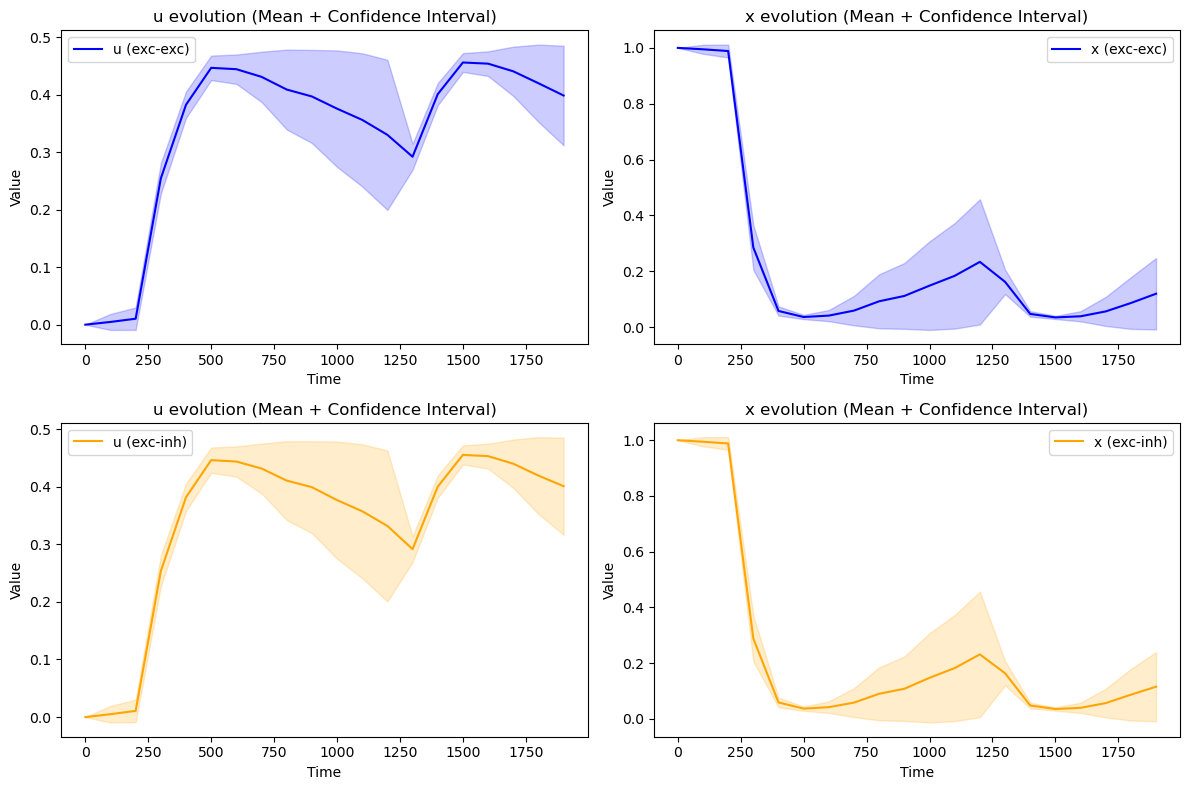

In [102]:
# Compute mean and standard deviation for confidence intervals
def compute_stats(values_list):
    means = [np.mean(values) for values in values_list]
    stds = [np.std(values) for values in values_list]
    return np.array(means), np.array(stds)

# Compute stats for u values
u_exc_exc_mean, u_exc_exc_std = compute_stats(u_values_exc_exc)
u_exc_inh_mean, u_exc_inh_std = compute_stats(u_values_exc_inh)
u_inh_exc_mean, u_inh_exc_std = compute_stats(u_values_inh_exc)
u_inh_inh_mean, u_inh_inh_std = compute_stats(u_values_inh_inh)

# Compute stats for x values
x_exc_exc_mean, x_exc_exc_std = compute_stats(x_values_exc_exc)
x_exc_inh_mean, x_exc_inh_std = compute_stats(x_values_exc_inh)
x_inh_exc_mean, x_inh_exc_std = compute_stats(x_values_inh_exc)
x_inh_inh_mean, x_inh_inh_std = compute_stats(x_values_inh_inh)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Line plot for u values with confidence interval
axes[0,0].plot(timesteps, u_exc_exc_mean, color="blue", label="u (exc-exc)")
axes[0,0].fill_between(timesteps, u_exc_exc_mean - u_exc_exc_std, u_exc_exc_mean + u_exc_exc_std, color="blue", alpha=0.2)
axes[1,0].plot(timesteps, u_exc_inh_mean, color="orange", label="u (exc-inh)")
axes[1,0].fill_between(timesteps, u_exc_inh_mean - u_exc_inh_std, u_exc_inh_mean + u_exc_inh_std, color="orange", alpha=0.2)
# axes[0].plot(timesteps, u_inh_exc_mean, color="green", label="u (inh-exc)")
# axes[0].fill_between(timesteps, u_inh_exc_mean - u_inh_exc_std, u_inh_exc_mean + u_inh_exc_std, color="green", alpha=0.2)
# axes[0].plot(timesteps, u_inh_inh_mean, color="purple", label="u (inh-inh)")
# axes[0].fill_between(timesteps, u_inh_inh_mean - u_inh_inh_std, u_inh_inh_mean + u_inh_inh_std, color="purple", alpha=0.2)
axes[0,0].set_title("u evolution (Mean + Confidence Interval)")
axes[0,0].set_xlabel("Time")
axes[0,0].set_ylabel("Value")
axes[0,0].legend()
axes[1,0].set_title("u evolution (Mean + Confidence Interval)")
axes[1,0].set_xlabel("Time")
axes[1,0].set_ylabel("Value")
axes[1,0].legend()

# Line plot for x values with confidence interval
axes[0,1].plot(timesteps, x_exc_exc_mean, color="blue", label="x (exc-exc)")
axes[0,1].fill_between(timesteps, x_exc_exc_mean - x_exc_exc_std, x_exc_exc_mean + x_exc_exc_std, color="blue", alpha=0.2)
axes[1,1].plot(timesteps, x_exc_inh_mean, color="orange", label="x (exc-inh)")
axes[1,1].fill_between(timesteps, x_exc_inh_mean - x_exc_inh_std, x_exc_inh_mean + x_exc_inh_std, color="orange", alpha=0.2)
# axes[1].plot(timesteps, x_inh_exc_mean, color="green", label="x (inh-exc)")
# axes[1].fill_between(timesteps, x_inh_exc_mean - x_inh_exc_std, x_inh_exc_mean + x_inh_exc_std, color="green", alpha=0.2)
# axes[1].plot(timesteps, x_inh_inh_mean, color="purple", label="x (inh-inh)")
# axes[1].fill_between(timesteps, x_inh_inh_mean - x_inh_inh_std, x_inh_inh_mean + x_inh_inh_std, color="purple", alpha=0.2)
axes[0,1].set_title("x evolution (Mean + Confidence Interval)")
axes[0,1].set_xlabel("Time")
axes[0,1].set_ylabel("Value")
axes[0,1].legend()
axes[1,1].set_title("x evolution (Mean + Confidence Interval)")
axes[1,1].set_xlabel("Time")
axes[1,1].set_ylabel("Value")
axes[1,1].legend()

plt.tight_layout()
plt.show()


# Spikes

Here we will simply plot the number of spikes of the network across the whole simulation

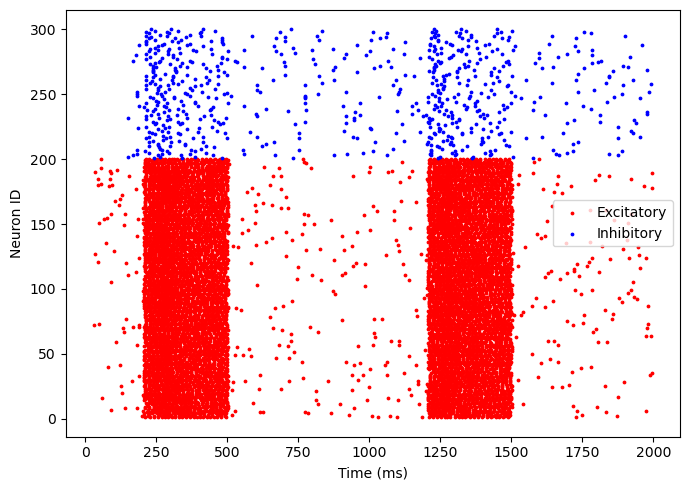

In [103]:
plot_spikes(sr_e, sr_i, sr_input)

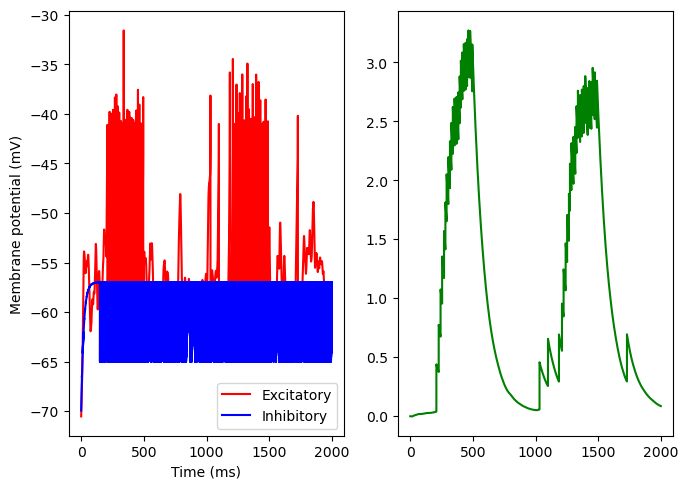

In [104]:
plot_voltages(mr_e, mr_i)

# Finding The Minimum Stimulus For Our Network to be Hyper-Excitable

## When is our network hyper-excitable?

To define a state of 'hyper-excitability', we first need to quantify the network's excitability. To achieve this, we will run multiple simulations while systematically increasing the thalamic input. By plotting the average firing rate of the neurons as a function of the thalamic input, we can determine how the network's excitability changes and identify the threshold at which hyper-excitability occurs

In [77]:
# I AM REIMPORTING EVERYTHING SO THAT I CAN RUN THE SIMULATION MULTIPLE TIMES WITHOUT HAVING TO RERUN THE WHOLE NOTEBOOK

import nest
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import importlib
import constants
import random
importlib.reload(constants)
from constants import *

nest.set_verbosity("M_ERROR") # SHUT UP NEST
nest.ResetKernel()

def create_populations():
    """
    Create populations of excitatory and inhibitory neurons with spatial distribution

    Returns:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """
    E_neuron_params = {
        "E_L": E_NEURON_E_L,
        "C_m": E_NEURON_C_M,
        "t_ref": E_NEURON_T_REF,
        "V_th": E_NEURON_V_TH,
        "V_reset": E_NEURON_V_RESET,
        "tau_syn_ex": E_NEURON_TAU_SYN_EX,
        "tau_syn_in": E_NEURON_TAU_SYN_IN,
        "a": ADAPTATION_a,         
        "b": ADAPTATION_b,         
        "tau_w": ADAPTATION_tau_w  
    }

    I_neuron_params = {
        "E_L": I_NEURON_E_L,
        "C_m": I_NEURON_C_M,
        "tau_m": I_NEURON_TAU_M,
        "t_ref": I_NEURON_T_REF,
        "V_th": I_NEURON_V_TH,
        "V_reset": I_NEURON_V_RESET,
        "tau_syn_ex": I_NEURON_TAU_SYN_EX,
        "tau_syn_in": I_NEURON_TAU_SYN_IN,
        "I_e": INH_BACKGROUND
    }

    pop_size_E = POP_SIZE_E
    pop_size_I = POP_SIZE_I

    nest.CopyModel("aeif_cond_alpha", "exc_iaf_psc_alpha")
    nest.SetDefaults("exc_iaf_psc_alpha", E_neuron_params)

    nest.CopyModel("iaf_psc_alpha", "inh_iaf_psc_alpha")
    nest.SetDefaults("inh_iaf_psc_alpha", I_neuron_params)

    pos_e = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )
    pos_i = nest.spatial.free(
        pos=nest.random.uniform(min=-0.5, max=0.5),
        num_dimensions=2
    )

    defaults = nest.GetDefaults("inh_iaf_psc_alpha")
    # print("Receptor types:", defaults.get("receptor_types", "No receptor_types entry found"))

    layer_e = nest.Create("exc_iaf_psc_alpha", n=pop_size_E, positions=pos_e)
    layer_i = nest.Create("inh_iaf_psc_alpha", n=pop_size_I, positions=pos_i)
    
    return layer_e, layer_i

def connect_pop_base(layer_e, layer_i):
    """
    Connect the populations with specific spatial synaptic rules

    Args:
        layer_e (list): List of excitatory neurons
        layer_i (list): List of inhibitory neurons
    """

    # Define a distance‐dependent connection rule
    distribution = nest.spatial_distributions.gaussian(nest.spatial.distance, std=GAUSSIAN_STD)
    conndict = {
        "rule": "pairwise_bernoulli",
        "p": nest.logic.conditional(distribution > DISTRIBUTION_THRESHOLD, distribution, 0),
        "mask": {"circular": {"radius": MASK_RADIUS}},
    }

    syn_params = {
        "U": 0.04,
        "u": 0.0,
        "tau_rec": 500.0,
        "tau_fac": 400.0,
        "weight" : EXC_WEIGHT
    }

    # Copy a generic synapse model
    nest.CopyModel("tsodyks_synapse", "synapse", syn_params)

    static_inh_params = {
        "weight": INH_WEIGHT,  
        "delay": DELAY_CONNECTION 
    }
    nest.CopyModel("static_synapse", "inhibitory_synapse", static_inh_params)
    # Define weights
    # exc_weight = EXC_WEIGHT
    # inh_weight = INH_WEIGHT

    # Make connections
    nest.Connect(layer_e, layer_i, conndict, syn_spec={"synapse_model": "synapse"})
    nest.Connect(layer_i, layer_e, conndict, syn_spec={"synapse_model": "inhibitory_synapse"})
    nest.Connect(layer_e, layer_e, conndict, syn_spec={"synapse_model": "synapse"})
    nest.Connect(layer_i, layer_i, conndict, syn_spec={"synapse_model": "inhibitory_synapse"})

    connections_exc = nest.GetConnections(synapse_model="synapse")
    connections_inh = nest.GetConnections(synapse_model="inhibitory_synapse")
    # print("Number of excitatory connections: ", len(connections_exc))
    # print("Number of inhibitory connections: ", len(connections_inh))

def create_thalamic_input(layer_e, firing_rate=THALAMIC_INPUT_FIRING_RATE, weight=THALAMIC_INPUT_WEIGHT, delay=THALAMIC_INPUT_DELAY):
    """
    Create a Poisson generator to simulate thalamic input to the excitatory neurons
    """
    thalamic_input = nest.Create("poisson_generator", params={"rate": firing_rate})
    nest.Connect(thalamic_input, layer_e, syn_spec={"weight": weight, "delay": delay}) 
    return thalamic_input

def create_dc_input(layer_e, start = DC_INPUT_START_1, stop=DC_INPUT_STOP_1):
    """
    Create a DC generator to simulate a constant input to the excitatory neurons
    """
    dc_input = nest.Create("dc_generator")
    
    nest.SetStatus(dc_input, {
        "amplitude": DC_INPUT_AMPLITUDE,  # pA (adjust based on your neuron model)
        "start": start,   # ms (start time)
        "stop": stop    # ms (stop time)
        })
    
    nest.Connect(dc_input, layer_e, syn_spec={"weight": DC_INPUT_WEIGHT, "delay": DC_INPUT_DELAY})

    return dc_input

def recording_devices(layer_e, layer_i, input = None):
    """
    Connect recording devices
    """
    sr_e = nest.Create("spike_recorder")
    sr_i = nest.Create("spike_recorder")
    nest.Connect(layer_e, sr_e)
    nest.Connect(layer_i, sr_i)

    if input:
        sr_input = nest.Create("spike_recorder")
        nest.Connect(input, sr_input)

    multimeter_e = nest.Create("multimeter", params={
    "record_from": ["V_m", "w"],  # Record membrane potential and adaptation
    "interval": 0.1})

    # multimeter_e = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    multimeter_i = nest.Create("multimeter", params={"record_from": ["V_m"], "interval": 0.1})
    nest.Connect(multimeter_e, layer_e[0])
    nest.Connect(multimeter_i, layer_i)

    sr_input = None
    
    return multimeter_e, multimeter_i, sr_e, sr_i, sr_input

def plot_spikes(sr_e, sr_i, sr_input = None):
    spike_events_e = nest.GetStatus(sr_e, "events")[0]
    spike_events_i = nest.GetStatus(sr_i, "events")[0]
    
    senders_e = spike_events_e["senders"]
    times_e = spike_events_e["times"]
    senders_i = spike_events_i["senders"]
    times_i = spike_events_i["times"]

    if sr_input:
        # poisson generator
        spike_events_input = nest.GetStatus(sr_input, "events")[0]
        # print(spike_events_input)
        senders_input = spike_events_input["senders"]
        times_input = spike_events_input["times"]

    dots_size = 3

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(times_e, senders_e, s=dots_size, label="Excitatory", color="red")
    ax.scatter(times_i, senders_i, s=dots_size, label="Inhibitory", color="blue")
    if sr_input:
        ax.scatter(times_input, senders_input, s=dots_size, label="Input", color="orange")
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("Neuron ID")
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_voltages(multimeter_e, multimeter_i):
    multimeter_events_e = nest.GetStatus(multimeter_e, "events")[0]
    multimeter_events_i = nest.GetStatus(multimeter_i, "events")[0]

    w = multimeter_events_e["w"]      # Adaptation variable
    senders_e = multimeter_events_e["senders"]  # Neuron IDs

    times_e = multimeter_events_e["times"]
    voltages_e = multimeter_events_e["V_m"]
    times_i = multimeter_events_i["times"]
    voltages_i = multimeter_events_i["V_m"]


    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(7, 5))
    ax1.plot(times_e, voltages_e, label="Excitatory", color="red")
    ax1.plot(times_i, voltages_i, label="Inhibitory", color="blue")
    ax1.set_xlabel("Time (ms)")
    ax1.set_ylabel("Membrane potential (mV)")
    ax1.legend()
    ax2.plot(times_e, w, label=f"Neuron {senders_e[0]}", color="green")
    plt.tight_layout()
    plt.show()

def plot_firing_rate(sr_e, sr_i, sim_time):
    bin_size = BIN_SIZE
    time_vector = np.arange(0, sim_time, bin_size)
    dc_current = np.zeros_like(time_vector, dtype=float)
    dc_current[(time_vector >= DC_INPUT_START) & (time_vector < DC_INPUT_STOP)] = DC_INPUT_AMPLITUDE

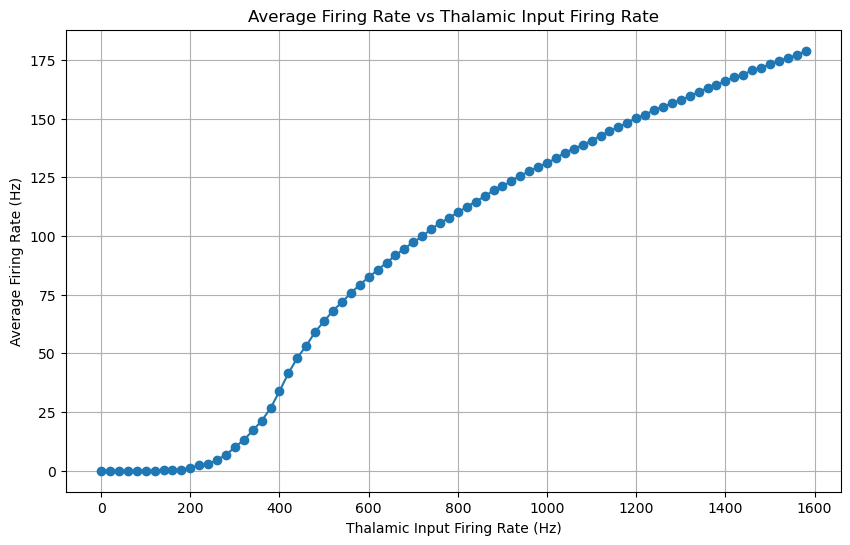

In [78]:
thalamic_firing_rates = [20 * i for i in range(80)]
firing_rates = []
sim_time = 150.0

for firing_rate in thalamic_firing_rates:
    nest.ResetKernel()
    layer_e, layer_i = create_populations()
    connect_pop_base(layer_e, layer_i)
    input = create_thalamic_input(layer_e, firing_rate=firing_rate)
    _, _, sr_e, sr_i, _ = recording_devices(layer_e, layer_i, input)
    nest.Simulate(sim_time)
    # Get recorded spikes
    spike_data = nest.GetStatus(sr_e, "events")[0]

    # Extract spike times and sender IDs
    spike_times = spike_data["times"]
    senders = spike_data["senders"]

    # Compute firing rate (spikes per second per neuron)
    num_spikes = len(spike_times)
    num_neurons = len(layer_e)
    firing_rate = num_spikes / (num_neurons * (sim_time / 1000))  # Hz
    firing_rates.append(firing_rate)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(thalamic_firing_rates, firing_rates, marker='o')
plt.xlabel('Thalamic Input Firing Rate (Hz)')
plt.ylabel('Average Firing Rate (Hz)')
plt.title('Average Firing Rate vs Thalamic Input Firing Rate')
plt.grid(True)
plt.show()


## Let's visualize the above

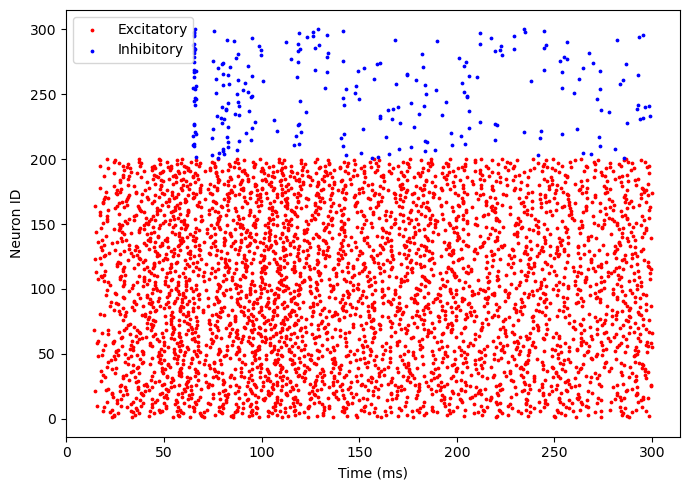

In [79]:
thalamic_firing_rate = 550

nest.ResetKernel()
layer_e, layer_i = create_populations()
connect_pop_base(layer_e, layer_i)
input = create_thalamic_input(layer_e, firing_rate=thalamic_firing_rate)
_, _, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, input)
nest.Simulate(300)
plot_spikes(sr_e, sr_i, sr_input)

## Pruning

To simulate synaptic pruning, we define a set of functions that selectively target and remove synapses, primarily long-range connections. We then test the network under increasing levels of stimulation to assess how its behavior deviates from that of our 'stable' baseline network

In [ ]:
## PRUNING

# Simulation

In [80]:
# nest.set_verbosity("M_ERROR") # nest shut up

# nest.ResetKernel()

# layer_e, layer_i = create_populations()
# connect_pop_base(layer_e, layer_i)
# input = create_thalamic_input(layer_e)

# multimeter_e, multimeter_i, sr_e, sr_i, sr_input = recording_devices(layer_e, layer_i, input)

# # Run simulation (adjust simulation time as needed)
# nest.Simulate(1000.0)

In [81]:
# # Plot outputs
# plot_spikes(sr_e, sr_i, sr_input)
# plot_voltages(multimeter_e, multimeter_i)
# multimeter_e_events = nest.GetStatus(multimeter_e, "events")[0]
# print(multimeter_e_events)